# Forest Fire Detection with transfer learning using VGG19

In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras.models import load_model
from keras.applications import VGG19
from keras import layers
from keras import Model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#train_dir = "/content/gdrive/My Drive/Escuela/Octavo Semestre/Fire_Original/Training"
#test_dir = "/content/gdrive/My Drive/Escuela/Octavo Semestre/Fire_Original/Test"

train_dir = "data/Training"
test_dir = "data/Test"

train_dir_extra = "data_extra/Training"
test_dir_extra = "data_extra/Test"

VGG_SIZE = 224

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                target_size=(VGG_SIZE, VGG_SIZE), 
                                                color_mode='rgb',
                                                batch_size=20,
                                                class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                target_size=(VGG_SIZE, VGG_SIZE),
                                                color_mode='rgb',
                                                batch_size=20,
                                                class_mode='binary')

train_generator_extra = train_datagen.flow_from_directory(train_dir_extra,
                                                target_size=(VGG_SIZE, VGG_SIZE), 
                                                color_mode='rgb',
                                                batch_size=20,
                                                class_mode='binary')

test_generator_extra = test_datagen.flow_from_directory(test_dir_extra,
                                                target_size=(VGG_SIZE, VGG_SIZE),
                                                color_mode='rgb',
                                                batch_size=20,
                                                class_mode='binary')

                                                

Found 39395 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.
Found 1520 images belonging to 2 classes.
Found 380 images belonging to 2 classes.


In [7]:
transfer_model = VGG19(include_top=True,
                        weights="imagenet",
                        classes=1000)
input = transfer_model.inputs

In [8]:
transfer_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
x = transfer_model.get_layer("block5_pool").output
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(4096, activation="relu")(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

classifier = Model(input, output_layer)

for layer in classifier.layers[:-4]:
    layer.trainable = False


classifier.get_layer("block5_conv1").trainable = True
classifier.get_layer("block5_conv2").trainable = True
classifier.get_layer("block5_conv3").trainable = True
classifier.get_layer("block5_conv4").trainable = True
classifier.get_layer("block5_pool").trainable = True

for layer in classifier.layers:
    print(f"Layer: {layer.name}, Trainable: {layer.trainable}")


classifier.summary()

Layer: input_1, Trainable: False
Layer: block1_conv1, Trainable: False
Layer: block1_conv2, Trainable: False
Layer: block1_pool, Trainable: False
Layer: block2_conv1, Trainable: False
Layer: block2_conv2, Trainable: False
Layer: block2_pool, Trainable: False
Layer: block3_conv1, Trainable: False
Layer: block3_conv2, Trainable: False
Layer: block3_conv3, Trainable: False
Layer: block3_conv4, Trainable: False
Layer: block3_pool, Trainable: False
Layer: block4_conv1, Trainable: False
Layer: block4_conv2, Trainable: False
Layer: block4_conv3, Trainable: False
Layer: block4_conv4, Trainable: False
Layer: block4_pool, Trainable: False
Layer: block5_conv1, Trainable: True
Layer: block5_conv2, Trainable: True
Layer: block5_conv3, Trainable: True
Layer: block5_conv4, Trainable: True
Layer: block5_pool, Trainable: True
Layer: flatten, Trainable: True
Layer: dense, Trainable: True
Layer: dense_1, Trainable: True
Layer: dense_2, Trainable: True
Model: "model"
______________________________________

In [10]:
classifier.compile(loss="binary_crossentropy",
                optimizer=optimizers.Adam(lr=0.005),
                metrics=["accuracy"])

In [11]:
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='models/vgg19_model_pretrain.h5', save_best_only=True, monitor='val_accuracy'),
]

history = classifier.fit(train_generator_extra, 
                        epochs=20, 
                        batch_size=40,
                        validation_data=test_generator_extra,
                        callbacks=callbacks)

Epoch 1/20
76/76 [==============================] - 36s 378ms/step - loss: 8090.8023 - accuracy: 0.5367 - val_loss: 0.6884 - val_accuracy: 0.6026
Epoch 2/20
76/76 [==============================] - 25s 331ms/step - loss: 0.7068 - accuracy: 0.5624 - val_loss: 13.2109 - val_accuracy: 0.5000
Epoch 3/20
76/76 [==============================] - 25s 332ms/step - loss: 2.8775 - accuracy: 0.5497 - val_loss: 0.6507 - val_accuracy: 0.5474
Epoch 4/20
76/76 [==============================] - 26s 334ms/step - loss: 0.5930 - accuracy: 0.6625 - val_loss: 0.4848 - val_accuracy: 0.7842
Epoch 5/20
76/76 [==============================] - 25s 333ms/step - loss: 0.4646 - accuracy: 0.7617 - val_loss: 0.4334 - val_accuracy: 0.8316
Epoch 6/20
76/76 [==============================] - 26s 333ms/step - loss: 0.3609 - accuracy: 0.8461 - val_loss: 0.4395 - val_accuracy: 0.8447
Epoch 7/20
76/76 [==============================] - 25s 332ms/step - loss: 0.3220 - accuracy: 0.8724 - val_loss: 0.3535 - val_accuracy: 0.

In [6]:
pretrained_clf = load_model("models/vgg19_model_pretrain.h5")
input = pretrained_clf.inputs

In [7]:
x = pretrained_clf.get_layer("block5_pool").output
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(4096, activation="relu")(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

classifier_f = Model(input, output_layer)

for layer in classifier_f.layers[:-4]:
    layer.trainable = False

for layer in classifier_f.layers:
    print(f"Layer: {layer.name}, Trainable: {layer.trainable}")

Layer: input_1, Trainable: False
Layer: block1_conv1, Trainable: False
Layer: block1_conv2, Trainable: False
Layer: block1_pool, Trainable: False
Layer: block2_conv1, Trainable: False
Layer: block2_conv2, Trainable: False
Layer: block2_pool, Trainable: False
Layer: block3_conv1, Trainable: False
Layer: block3_conv2, Trainable: False
Layer: block3_conv3, Trainable: False
Layer: block3_conv4, Trainable: False
Layer: block3_pool, Trainable: False
Layer: block4_conv1, Trainable: False
Layer: block4_conv2, Trainable: False
Layer: block4_conv3, Trainable: False
Layer: block4_conv4, Trainable: False
Layer: block4_pool, Trainable: False
Layer: block5_conv1, Trainable: False
Layer: block5_conv2, Trainable: False
Layer: block5_conv3, Trainable: False
Layer: block5_conv4, Trainable: False
Layer: block5_pool, Trainable: False
Layer: flatten, Trainable: True
Layer: dense_3, Trainable: True
Layer: dense_4, Trainable: True
Layer: dense_5, Trainable: True


In [8]:
classifier_f.compile(loss="binary_crossentropy",
                optimizer=optimizers.Adam(lr=0.005),
                metrics=["accuracy"])

In [11]:
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='models/vgg19_model_ex_trained.h5', save_best_only=True, monitor='val_accuracy'),
]

history = classifier_f.fit(train_generator, 
                        epochs=20, 
                        batch_size=40,
                        validation_data=test_generator,
                        callbacks=callbacks)

Epoch 1/20
1970/1970 [==============================] - 1276s 645ms/step - loss: 0.5932 - accuracy: 0.7349 - val_loss: 0.8963 - val_accuracy: 0.6218
Epoch 2/20
1970/1970 [==============================] - 618s 314ms/step - loss: 0.5013 - accuracy: 0.7679 - val_loss: 1.1536 - val_accuracy: 0.6198
Epoch 3/20
1970/1970 [==============================] - 634s 322ms/step - loss: 0.4891 - accuracy: 0.7767 - val_loss: 1.3716 - val_accuracy: 0.6263
Epoch 4/20
1970/1970 [==============================] - 621s 315ms/step - loss: 0.4898 - accuracy: 0.7758 - val_loss: 1.1106 - val_accuracy: 0.6175
Epoch 5/20
  29/1970 [..............................] - ETA: 9:02 - loss: 0.4607 - accuracy: 0.7801

KeyboardInterrupt: 

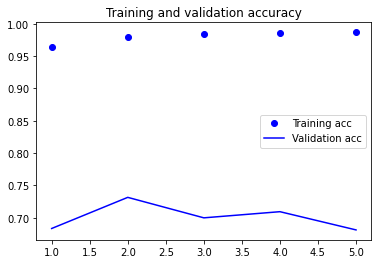

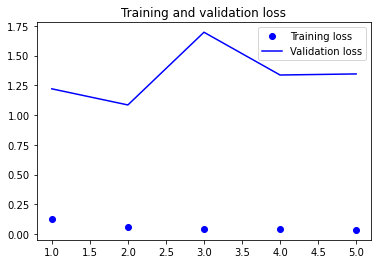

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [18]:
result = classifier.evaluate(test_generator)
print(f"Test loss: {result[0]}, Test accuracy: {result[1]}")

ResourceExhaustedError:  OOM when allocating tensor with shape[20,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_2/block1_conv1/Relu (defined at <ipython-input-15-4e19c09292de>:10) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_test_function_33694]

Function call stack:
test_function


In [17]:
from keras import models

#model_path = "/content/gdrive/My Drive/Escuela/Octavo Semestre/DSDM/models/vgg19_model_best.h5"
model_path = 'models/vgg19_model.h5'

model = models.load_model(model_path)
result = model.evaluate(test_generator)
print(f"Test loss: {result[0]}, Test accuracy: {result[1]}")

ResourceExhaustedError: OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]